# Algorithm to monitor NIFTY50 stocks.
**Model also performs predictions on a stock of choice**

Importing necessary packages

In [52]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
sns.set_theme()
%autosave 30

Autosaving every 30 seconds


In [2]:
dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',parse_dates=True)
comps = dft.Symbol.unique()

In [3]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [4]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


# Indicators

- **Simple Moving Average**
- **Exponential Moving Average**

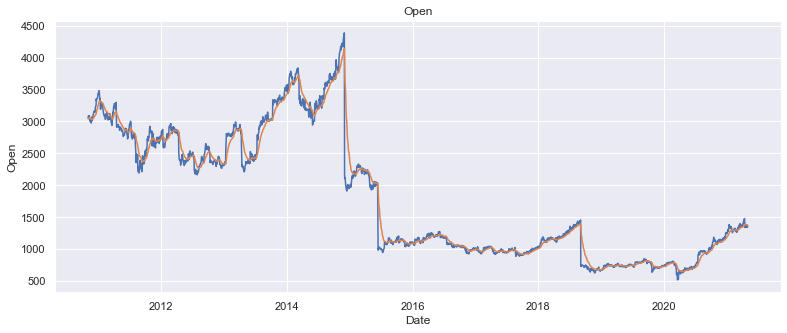

In [80]:
def plotstock(stock,feature='Open'):         
    plt.figure(figsize=(13,5))
    dat = dft[dft.Symbol == stock]
    
    if type(feature) == type([]):
        for i in feature:
            sns.lineplot(data = dat[i])
        
    else:
        sns.lineplot(data = dat[feature])
        datrol = dat[feature].rolling(window =30).mean()
        datrol = dat[feature].ewm(span=26,min_periods=0,adjust=False,ignore_na=False).mean()
        sns.lineplot(data = datrol)
    plt.title(feature)
  

feature = 'Close'
stock = np.random.choice(comps)
plotstock(stock=stock,feature='Open')

    

[]

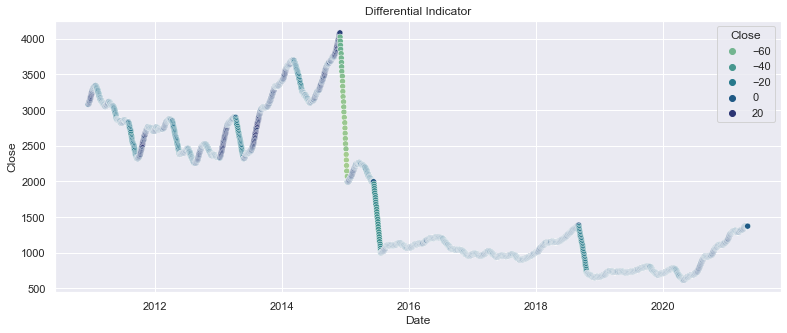

In [81]:
dat = dft[dft.Symbol == stock].rolling(window =30).mean()
#dat = dft[dft.Symbol == stock].ewm(span=20,min_periods=0,adjust=False,ignore_na=False).mean()
#datrol = dat[feature].rolling(window =30).mean()
datf = dat[feature].diff()
datf1 = dat[feature].pct_change()


datf.fillna(0,inplace=True)

plt.figure(figsize=(13,5)) 
sns.scatterplot(data = dat,x = dat.index,y = feature,hue=datf,palette='crest')
#sns.scatterplot(data = dat,x = dat.index,y = dat[feature],hue=datf,palette='crest')
plt.title('Differential Indicator')
plt.plot()

[]

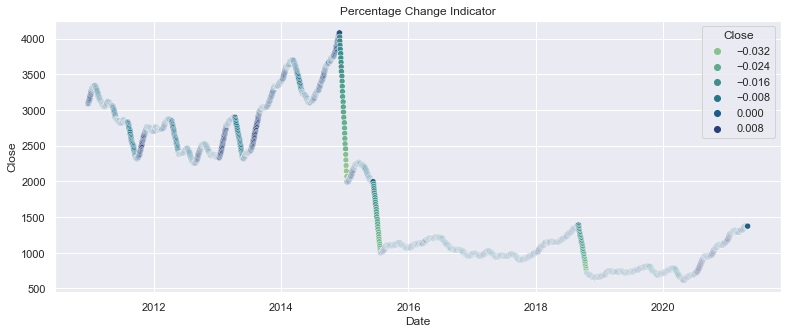

In [82]:
plt.figure(figsize=(13,5)) 
sns.scatterplot(data = dat,x = dat.index,y = feature,hue=datf1,palette='crest')
#sns.scatterplot(data = dat,x = dat.index,y = dat[feature],hue=datf,palette='crest')
plt.title('Percentage Change Indicator')
plt.plot()

- **MACD**

In [83]:
def indicator_macd(data,slow=26,fast=12,smooth=9):
    #SLOW
    ewa1 = data.ewm(span=slow,min_periods=0,adjust=False).mean()
    #FAST
    ewa2 = data.ewm(span=fast,min_periods=0,adjust=False).mean()
    
    macd = ewa2-ewa1
    
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    
    hist = macd - signal
    
    ret = {'slow':ewa1.values,'fast':ewa2.values,'macd':macd.values,
           'signal':signal,
           'histogram':hist.values,'time':data.index}
    
    return pd.DataFrame(ret,index=ret['time'])
    

In [84]:
cc = np.random.choice(comps)
dat = dft[dft.Symbol == cc]
cc

'AXISBANK'

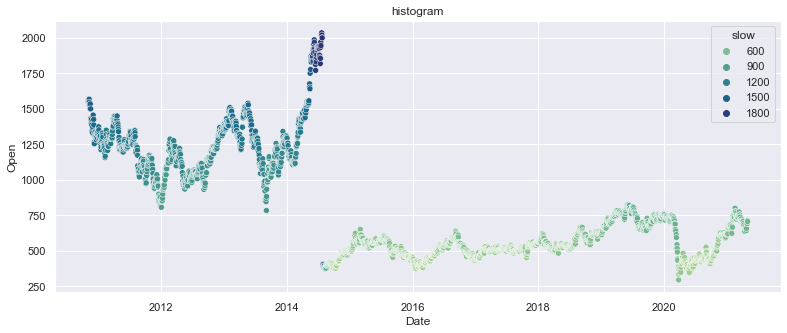

In [85]:
def plot_macd(data,feature='macd',standalone = True):
    ret = indicator_macd(data)
    plt.figure(figsize=(13,5)) 
    if standalone == True:
        sns.lineplot(data = ret,x = ret.index,y = feature,palette='crest')
    else:        
        sns.scatterplot(x = data.index,y = data,hue=ret['slow'],palette='crest')
    plt.title(feature)
    plt.plot()
    return ret


_ = plot_macd(dat['Open'],feature='histogram',standalone=False)

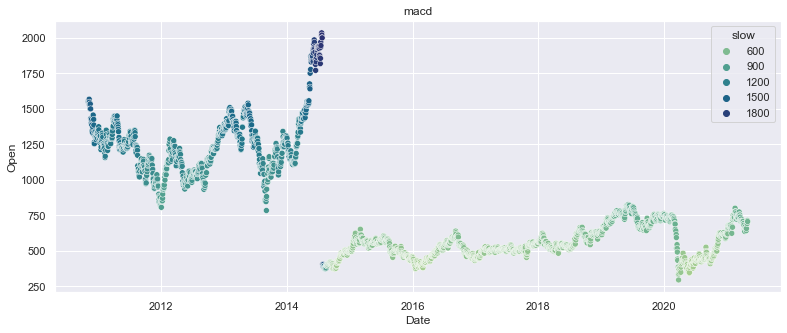

In [86]:
_ = plot_macd(dat['Open'],feature='macd',standalone=False)

- **RSI**

In [137]:
cc = np.random.choice(comps)
dat = dft[dft.Symbol == cc]
cc

'ICICIBANK'

In [152]:
def indicator_rsi(data, lookback=14):
    ret = data.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    #rsi.dropna(inplace=True)
    #rsi.fillna()
    #rsi.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    return rsi
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

tt = indicator_rsi(dat['Close'])
tt,dat.shape

(0              NaN
 1       100.000000
 2        84.019478
 3        85.883592
 4        76.237345
            ...    
 2593     53.964354
 2594     56.059226
 2595     61.616252
 2596     61.639369
 2597     54.265703
 Length: 2598, dtype: float64,
 (2598, 9))

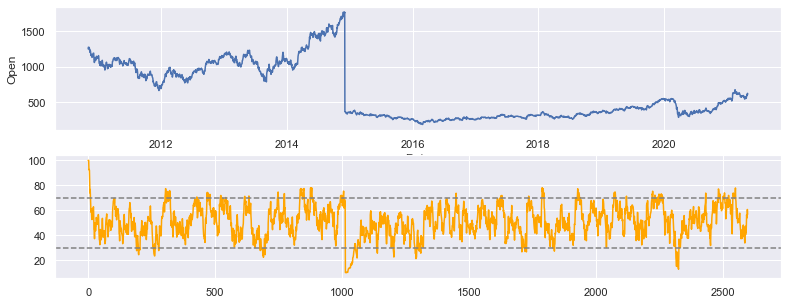

In [141]:
def plot_rsi(data,standalone = True):
    ret = indicator_rsi(data)
    if standalone == True:
        fig, ax = plt.subplots(2, 1, figsize=(13,5))
        sns.lineplot(data = data,ax=ax[0])
        sns.lineplot(data = ret,ax=ax[1],color = 'orange')
        ax[1].axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
        ax[1].axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
    else:    
        plt.figure(figsize = (10,7))
        sns.scatterplot(data = data,x = data.index, y = data.values,hue=ret,palette='crest')
        plt.title('RSI Index')
    
    plt.plot()
    return ret


_= plot_rsi(dat['Open'],standalone=True)

In [162]:
ret = indicator_rsi(dat['Close'])
ret

0              NaN
1       100.000000
2        84.019478
3        85.883592
4        76.237345
           ...    
2593     53.964354
2594     56.059226
2595     61.616252
2596     61.639369
2597     54.265703
Length: 2598, dtype: float64

In [159]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(1,len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(dat['Close'], rt)

In [156]:
len(rsi_signal)

2597

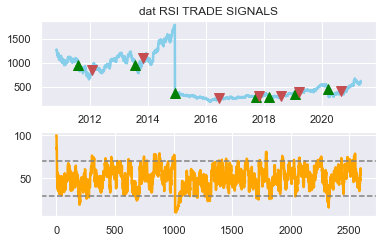

In [160]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(dat['Close'], linewidth = 2.5, color = 'skyblue', label = 'dat')
ax1.plot(dat.index[1:], buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(dat.index[1:], sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('dat RSI TRADE SIGNALS')
ax2.plot(rt, color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

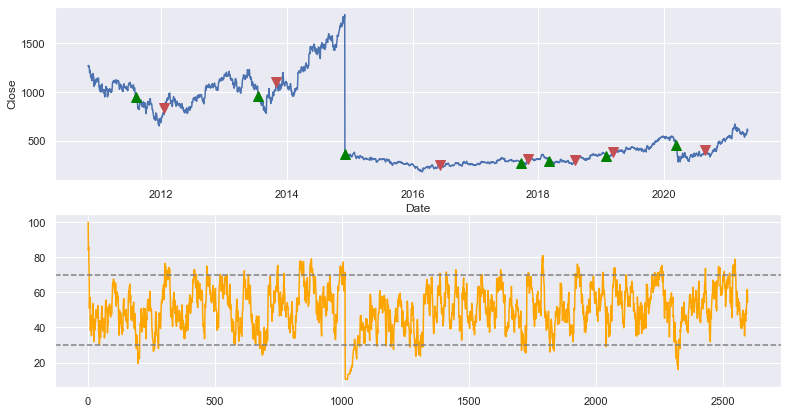

In [164]:
fig, ax = plt.subplots(2, 1, figsize=(13,7))
sns.lineplot(data = dat['Close'],ax=ax[0])
ax[0].plot(dat.index[1:], buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax[0].plot(dat.index[1:], sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
sns.lineplot(data = ret,ax=ax[1],color = 'orange')
ax[1].axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax[1].axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')

# Rough Work

comps = listdir(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50')
dates = []
for nm in comps:
    df = pd.read_csv(rf'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\{nm}')
    #print(nm)
    print(df.Date[0],nm)
    dates.append(df.Date[0])

    
comps = listdir(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50')
flag = True
for nm in tqdm(comps):
    #print(nm)
    if flag == True:
        dft = pd.read_csv(rf'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\{nm}')
        dft['Date'] = pd.to_datetime(dft['Date'])
        dft.set_index('Date',inplace=True)
        dft.sort_index(inplace=True)
        dft = dft.loc['2010-11-04 00:00:00':]
        #print(dft)
        
        #dft = dft.groupby(level=0).mean()
        dft.Symbol = nm[:-4]
        flag = False
        continue
    df = pd.read_csv(rf'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\{nm}')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df.sort_index(inplace=True)
    df = df.loc['2010-11-04 00:00:00':]
    df.Symbol = nm[:-4]
    dft = pd.concat([dft,df])
dft.columns

In [28]:
#dft[cols].to_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv')

In [16]:
'''len(dft.Symbol.unique())
cols = dft.Symbol.unique()
for i in dft.Symbol.unique():
    print(dft[dft.Symbol == i].shape,i)'''

'len(dft.Symbol.unique())\ncols = dft.Symbol.unique()\nfor i in dft.Symbol.unique():\n    print(dft[dft.Symbol == i].shape,i)'